# Lab12 - Training Deep Convolutional Neural Network
- Name1, Student's ID1
- Name2, Student's ID2


Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use MNIST and Cat vs Dog dataset.

See http://yann.lecun.com/exdb/mnist <br>
See https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# %load _utils
# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['sparse_categorical_accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_sparse_categorical_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)

    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### 1. Load MNIST dataset

In [ ]:
### Load dataset ###
(X_train,y_train), (X_test,y_test) = mnist.load_data()
####################

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

### 2. Preprocess data

In [ ]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    data = data.astype('float32')/255.
    return data

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [ ]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [ ]:
BATCH_SIZE = 32

### 3. Build a convolutional neural network
Try to build a network that have a same or out perform our previous fully-connect model.

In [ ]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='elu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(10,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.save('baseline_model.h5')
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4. Trainig CNN Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

Epoch 1/20
844/844 [==============================] - 20s 9ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.0622 - val_sparse_categorical_accuracy: 0.9830
Epoch 2/20
844/844 [==============================] - 6s 8ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.0637 - val_sparse_categorical_accuracy: 0.9828
Epoch 3/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0607 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/20
844/844 [==============================] - 6s 8ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0493 - val_sparse_categorical_accuracy: 0.9865
Epoch 5/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0590 - val_sparse_categorical_accuracy: 0.9868
Epoch 6/20
844/844 [==============================] - 6s 7ms/step - loss: 0.0626 - sparse_categoric

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


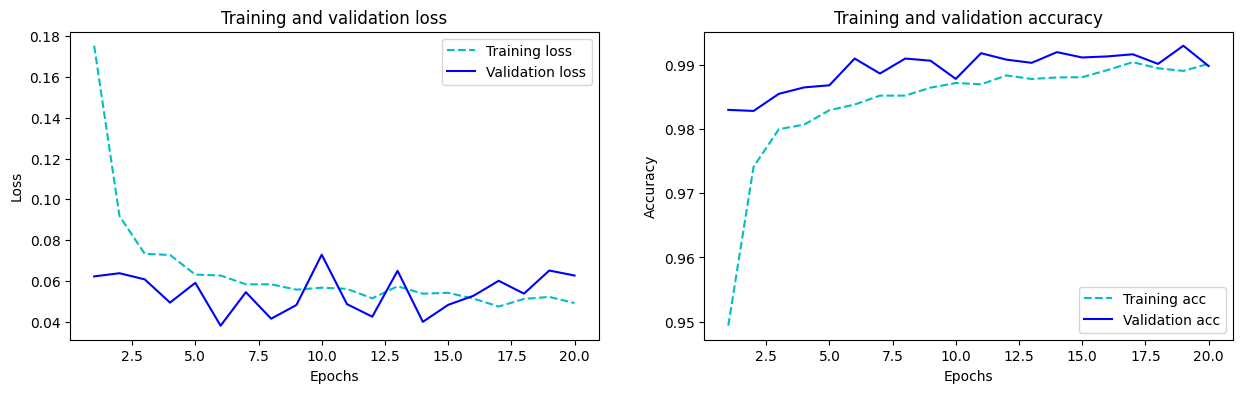

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr20.h5')
show_result(history)

```verbose=False``` will show you nothing (silent)

```verbose=TRUE``` will show you an animated progress bar like this:
[==============================]


Last train accuracy: 0.9934999942779541
Last validation accuracy: 0.9928333163261414


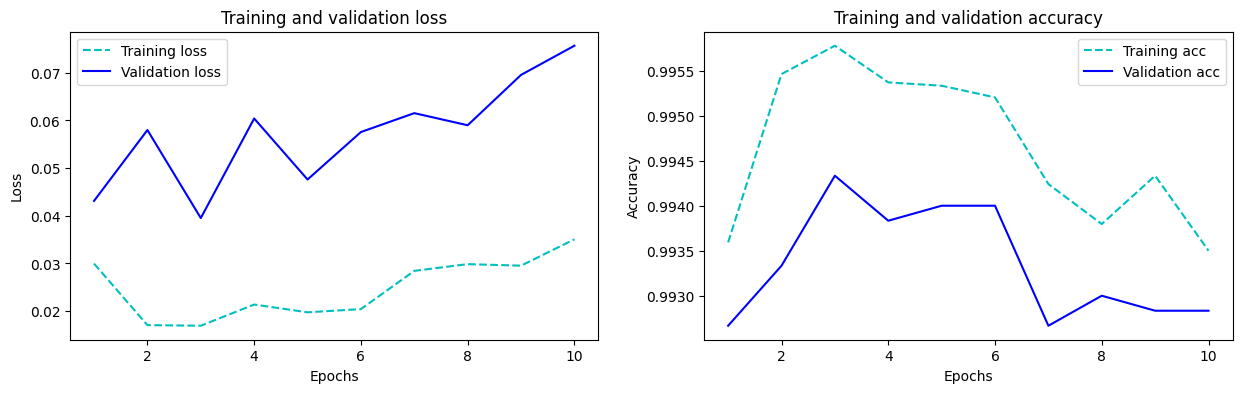

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=False)
cnn.save('baseline_model_itr10_verboseFalse.h5')
show_result(history)

Last train accuracy: 0.9946481585502625
Last validation accuracy: 0.9931666851043701


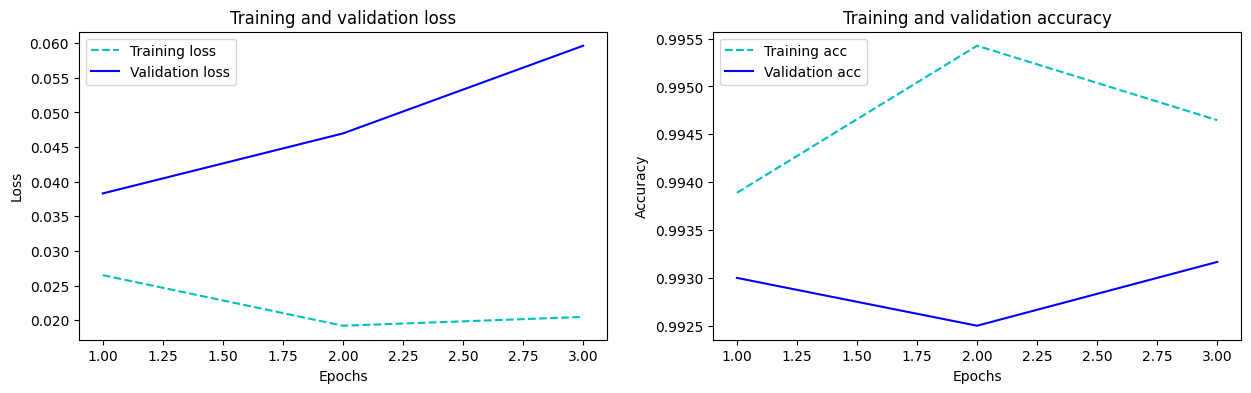

In [ ]:
cnn = models.load_model('baseline_model_itr20.h5')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) #Stop When Val_Loss No change
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stop], # EarlyStoping
                  verbose=False)
cnn.save('baseline_model_itr10_earlystop.h5')
show_result(history)

### 5. Evaluate your model
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [ ]:
pred_class = evaluation_report(cnn,X_test,y_test)

313/313 [==============================] - 1s 2ms/step
[[ 977    0    0    0    0    0    1    2    0    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   1    1 1026    1    1    0    0    2    0    0]
 [   0    0    1 1007    0    2    0    0    0    0]
 [   0    1    1    0  979    0    0    0    0    1]
 [   1    0    0    2    0  886    2    0    1    0]
 [   2    3    0    0    1    1  950    0    1    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   1    0    1    0    1    1    0    2  966    2]
 [   0    1    0    0   11    1    0    5    2  989]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99  

### 5.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(62, 28, 28)


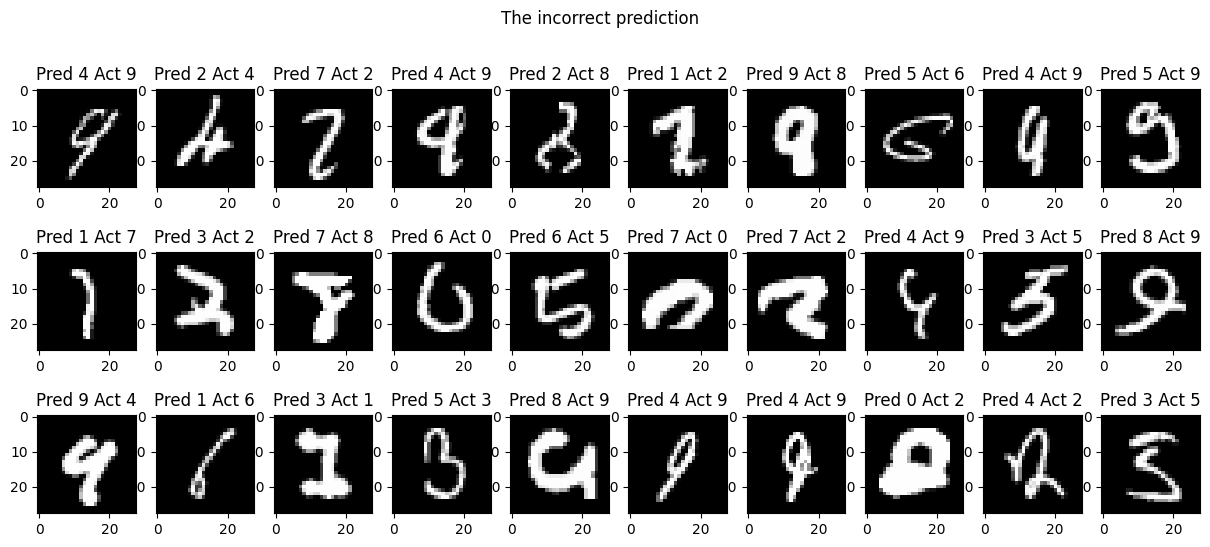

In [ ]:
show_false_prediction(pred_class, X_test, y_test)

**Discuss the results**

*Discussion*
<font color='orange'> จาก Confusion Matrix จะเห็นได้ว่าใน Class 9 เกิดการ Missclassify มากที่สุด และ ทำการแสดง False Prediction โดยการ Show Input Data ทั้งหมดที่ทำนายผิด 62 ตัว ซึ่งการเกิด False Prediction อาจเกิดจากหลายสาเหตุ ไม่ว่าจะเป็น ลายมือ หรือ ประสิทธิภาพของ Model ที่อาจจะมีความ Overfitting ,ความคล้ายคลึงกันของตัวเลข ตัวเลข 9 อาจมีลักษณะที่คล้ายคลึงกับตัวเลขอื่น ๆ เช่น 7 หรือ 4 ทำให้ความคลาดเคลื่อนการแยกแยะตัวเลข ทำให้ Predict ผิด

### 5.3 Data Augmentation

Using the ```ImageDataGenerator``` module to generate more data. This technique is called data augmentation. It help generate more variation of the data which help prevent overfit and generalize better.

Lookup in the Keras document to see what method does it provide. https://keras.io/preprocessing/image

Becasue we want to build a data generator object, we have to re-load the data and specify rescale argument in ImageDataGenerator module.

In [ ]:
# Re-load the image data
(X_train,y_train), (X_test,y_test) = mnist.load_data()

# Because the ImageDataGenerator require tensor of 4 dimension
# Reshape data to 4 dimension (batch, width, height, channel)
def reshape_gray(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    return data

X_train = reshape_gray(X_train)
X_test = reshape_gray(X_test)

# split to validation set and train set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [ ]:
# update global variable
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

BATCH_SIZE = 32

In [ ]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Create an Iterator object.
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

<ipython-input-19-396b1437952a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last train accuracy: 0.9319815039634705
Last validation accuracy: 0.9856666922569275


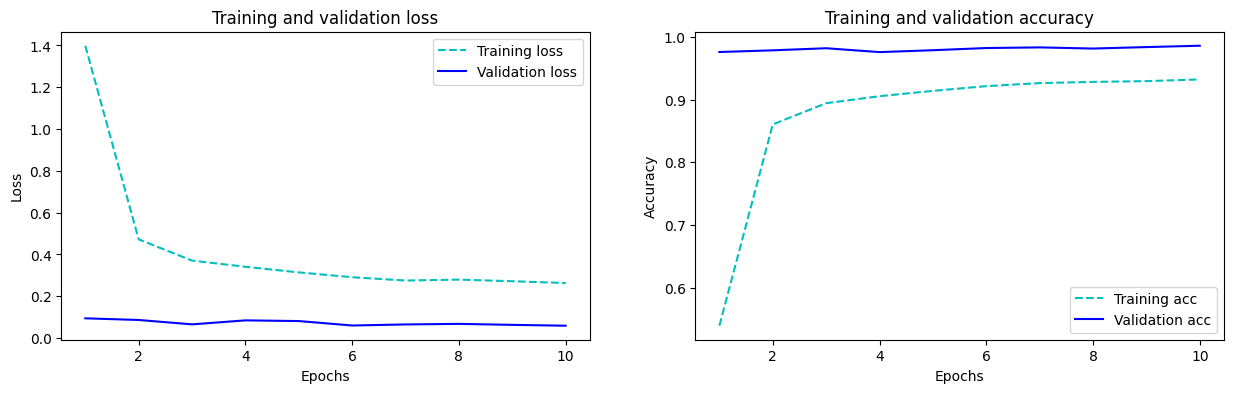

In [ ]:
# Using fit_generator to train your model. We don't need to specify the batch size since we already done that when we create Iterator
history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=None,
                              validation_data=validate_generator,
                              workers=8, use_multiprocessing=True)
cnn.save('baseline_model_itr10_data_aug.h5')
show_result(history)

<ipython-input-20-ac23c5d585be>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,


Last train accuracy: 0.9355740547180176
Last validation accuracy: 0.984333336353302


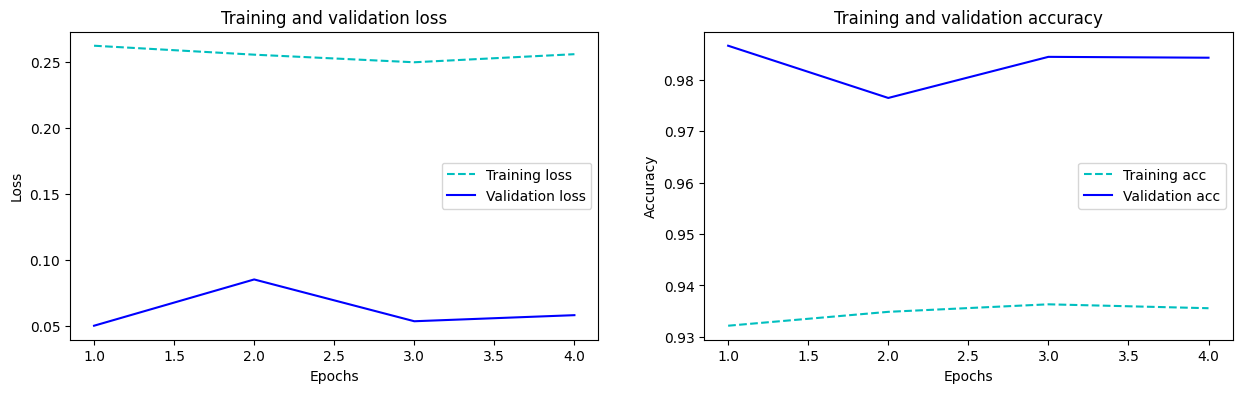

In [ ]:
# Add early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Load previous model
cnn = models.load_model('baseline_model_itr10_data_aug.h5')


history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=[early_stop],
                              validation_data=validate_generator)

cnn.save('baseline_model_itr10_data_aug_earlystop.h5')
show_result(history)

<ipython-input-22-2657db9c7e7c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,


Last train accuracy: 0.9481666684150696
Last validation accuracy: 0.984666645526886


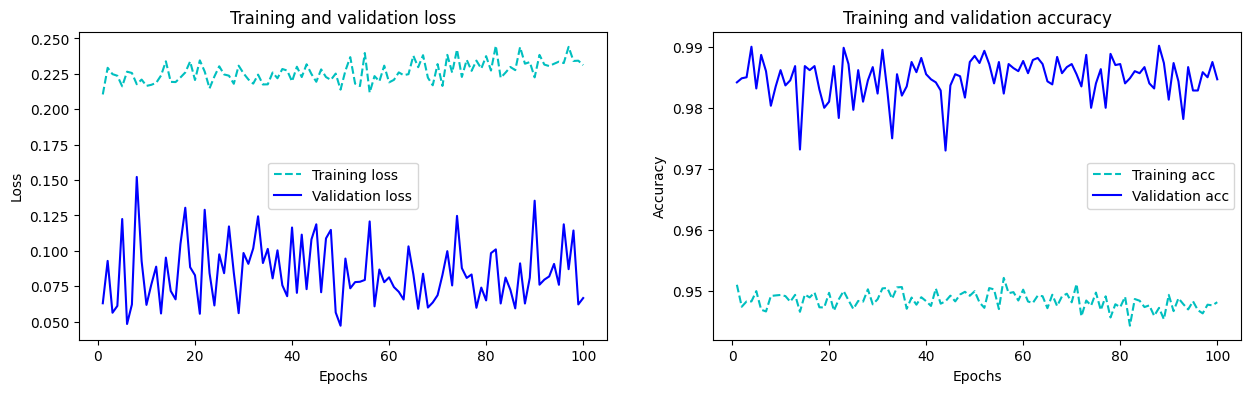

In [ ]:
# Let it run
history = cnn.fit_generator(train_generator,
                              epochs=100,
                              verbose=0,
                              validation_data=validate_generator)

cnn.save('baseline_model_itr100_data_aug.h5')
show_result(history)


**5.5 Compare the result**

Compare the result between a model with data augmentation and without data augmentation

ANS :
จากกราฟ Loss and Acc ของ Model ที่ Input Data ใช้การ Augmentation
 จะเห็นได้ว่าโมเดลที่มีการใช้ Data Augmentation:
- ประสิทธิภาพในการทำนายอาจมีประสิทธิภาพในการทำนายที่ดีขึ้น เนื่องจากมีการสร้างข้อมูลเพิ่มเติมจากการปรับแต่งข้อมูลที่มีอยู่ เช่น การหมุนภาพ การสะท้อนภาพ หรือการปรับขนาด ซึ่งช่วยให้โมเดลมีความสามารถในการทำนายที่มั่นคงมากขึ้นในสถานการณ์ที่ข้อมูลเดิมไม่เพียงพอ หรือลายมือไม่สวยบ้าง เขียนตัวเอียงบ้าง
- ช่วยลดโอกาสในการเกิด overfitting โดยทำให้โมเดลมีโอกาสเรียนรู้และทำนายข้อมูลที่เป็นไปได้มากขึ้น โดยที่ไม่ได้เกิดการจดจำข้อมูลเดิมไว้เฉย ๆ
- โมเดลที่มีการใช้ Data Augmentation อาจมีความยืดหยุ่นในการทำนายในสถานการณ์ที่ข้อมูลมีความแตกต่างหรือการเปลี่ยนแปลงเล็กน้อย

### 6. Visualize Layer Activation
**Note:** the function is defined above.

In [25]:
# Create an activation model (the model with convolution layer only)

num_conv = 4# Number of convolutional layer in your model (if more than 4, just used 4)
layer_outputs = [layer.output for layer in cnn.layers[:num_conv]]
activation_model = models.Model(inputs=cnn.input, outputs=layer_outputs)
activation_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
Total params: 28064 (109.62 KB)
Trainable params: 28064 (109.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
from keras.preprocessing import image

# load image to feed into network
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/test_data_1.png',target_size=(28,28),grayscale=True)
img_tensor = image.img_to_array(img)

# Preprocess data
img_tensor = np.expand_dims(image.img_to_array(img),axis=0)/255.

# Feed into activation model to get an activation value
activation = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 291ms/step


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


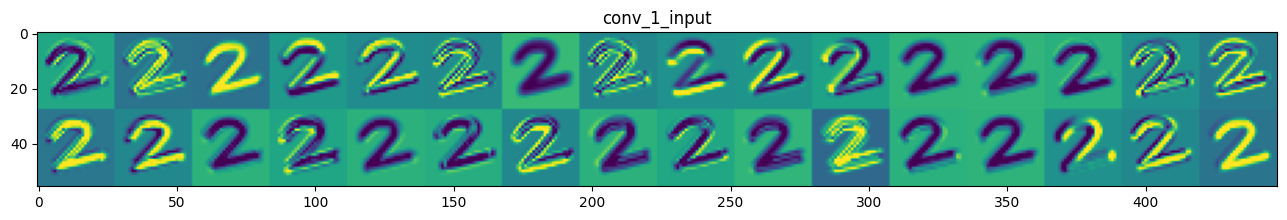

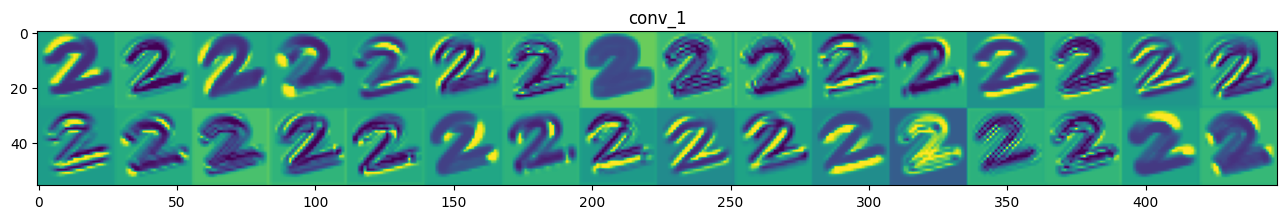

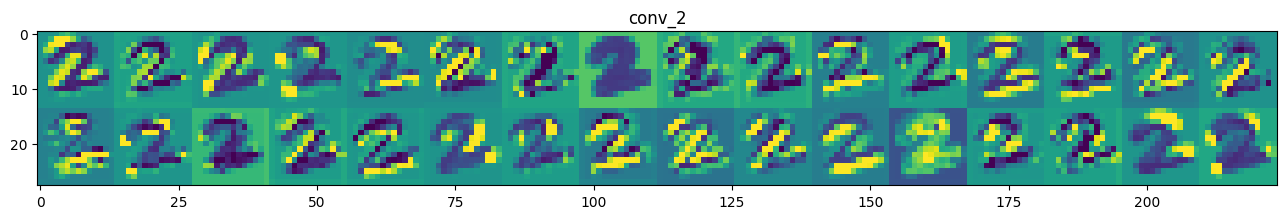

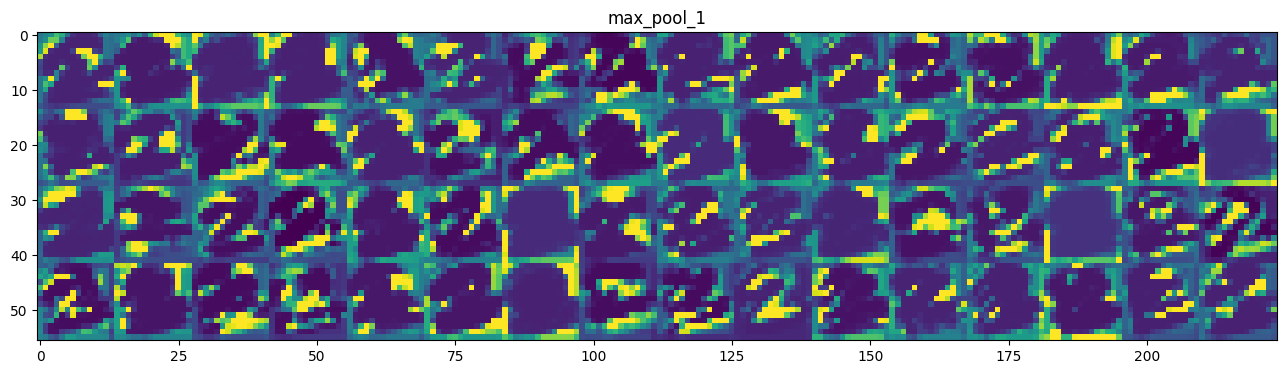

In [31]:
### Feed your activation, model and number of layer you want to see
show_layer_activation(activation,activation_model,num_layer=4)

**What do you think the network can detect?**
- Discuss  

เลเยอร์ที่มีการตรวจจับ (detection) หมายเลข 1, 2, และ 3 ของโมเดลที่ถูกส่งเข้ามา ซึ่งน่าจะเป็นเลเยอร์ Convolutional หรือเลเยอร์ที่มีการทำงานที่เกี่ยวข้องกับการตรวจจับวัตถุ (object detection) หรือคุณลักษณะของภาพในระดับต่ำ

การแสดงผล activation ของเลเยอร์ที่ตรวจจับอาจแสดงให้เห็นถึงลักษณะของการกระตุ้น (activation) ที่เกิดขึ้นหลังจากการทำงานของโมเดล ที่นี้อาจเป็นการแสดงผลของลักษณะเฉพาะที่ตรวจจับได้ เช่น รูปร่างของเลขหรือวัตถุที่ต้องการตรวจจับในภาพ

### 7. Transfer Learning
- What is transfer learning https://towardsdatascience.com/transfer-learning-946518f95666
- which transfer learning method to use https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

The following is a tutorial code to load and freeze some layer. Keras also come with a build-in pre-train network on imageNet dataset (See www.image-net.org)

Keras Pre-train Network https://keras.io/applications

#### 7.1.1 Use Build-in Pre-train Network
Keras come with a build-in pre-train network that let you download and use it in your problem. You can import only model structure or import neuron weight that had been train on imageNet.

In [32]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150,150,3))

58889256/58889256 [==============================] - 0s 0us/step


In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

#### 7.1.2 Use Our Pre-train Network

When we are doing the deep learning/machine learning project, sometime, we may encounter a similar problem. After several project, we will have many existing model that we experiment and develop. We can used these model as a pre-train network to solve a new problem. This can save a hugh cost (time and money) and jump start our new project very quickly.

In [34]:
prev_cnn = models.load_model('baseline_model_itr20.h5')
prev_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [35]:
# Use .pop() to remove the last layer
# In this case, we want to remove last two layer

prev_cnn.pop()
prev_cnn.pop()

In [36]:
# See how our model change
prev_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

For both method, if you want to change input size of your network, you have to create a model using functional API.
See https://keras.io/models/model

#### 7.2.1 Freezing layer - All

In [37]:
# If we don't want to train these layer, we have to freeze these layer.
# Note that if we want a pre-train as a weight initializer, we don't have to freeze the layer.

prev_cnn.trainable = False

#### 7.2.2 Freezing layer - Specific layer

In [38]:
# Freeze a specific layers
# Freeze first 3 layer
for i in range(3):
    prev_cnn.layers[i].trainable = False

#### 7.3 Connnect your model

In [39]:
# Time to create a new model
new_cnn = models.Sequential()

# Add convolutional layer as a pre-train network
new_cnn.add(prev_cnn)

# Define fully-connect layer
new_cnn.add(layers.Dense(256,activation='elu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(10,activation='softmax',name='output'))

# Show how your network looklike
new_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               868064    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 936426 (3.57 MB)
Trainable params: 68362 (267.04 KB)
Non-trainable params: 868064 (3.31 MB)
_________________________________________________________________


After this process, you can use your network as the way you like.

Epoch 1/20
844/844 [==============================] - 7s 6ms/step - loss: 8.7554 - sparse_categorical_accuracy: 0.9699 - val_loss: 3.1559 - val_sparse_categorical_accuracy: 0.9850
Epoch 2/20
844/844 [==============================] - 4s 5ms/step - loss: 2.5407 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.7877 - val_sparse_categorical_accuracy: 0.9882
Epoch 3/20
844/844 [==============================] - 5s 6ms/step - loss: 1.3678 - sparse_categorical_accuracy: 0.9845 - val_loss: 1.3457 - val_sparse_categorical_accuracy: 0.9862
Epoch 4/20
844/844 [==============================] - 5s 6ms/step - loss: 0.8344 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.9878
Epoch 5/20
844/844 [==============================] - 4s 5ms/step - loss: 0.6636 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.6672 - val_sparse_categorical_accuracy: 0.9860
Epoch 6/20
844/844 [==============================] - 5s 6ms/step - loss: 0.4720 - sparse_categorica

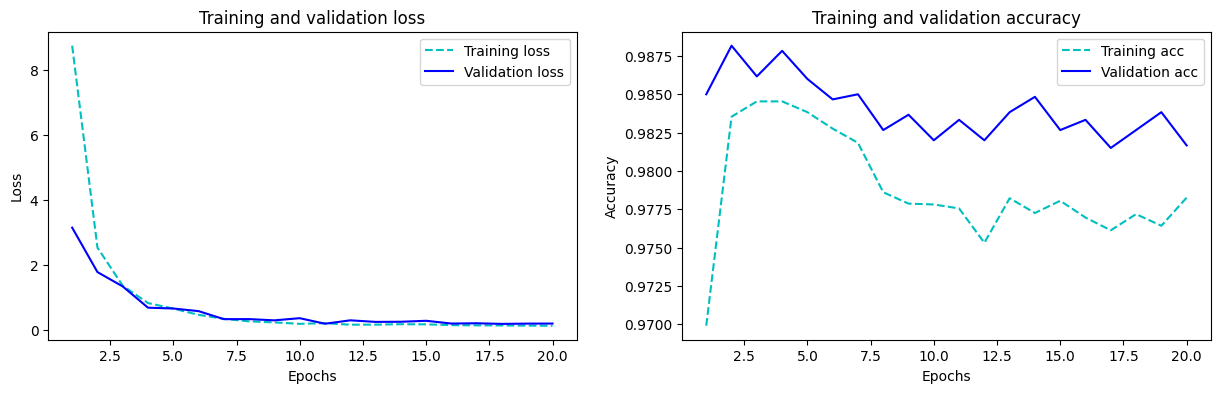

In [40]:
new_cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])

history = new_cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
new_cnn.save('transfer_learning_model_itr20.h5')

show_result(history)

In [41]:
pred_class = evaluation_report(new_cnn,X_test,y_test)

313/313 [==============================] - 2s 6ms/step
[[ 971    0    0    0    0    1    4    0    3    1]
 [   0 1120    0    1    9    0    2    2    1    0]
 [   1    1 1015    0   10    0    0    4    1    0]
 [   0    0    0 1000    4    4    0    0    0    2]
 [   0    0    0    0  960    0    5    0    3   14]
 [   1    0    0    6    2  881    1    0    0    1]
 [   2    1    0    0    3    6  945    0    1    0]
 [   0    1    4    2   14    0    0 1004    0    3]
 [   0    0    1    1    6    2    1    0  963    0]
 [   0    1    1    2   21    2    0    1    3  978]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.93      0.98      0.95       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99  

(163, 28, 28)


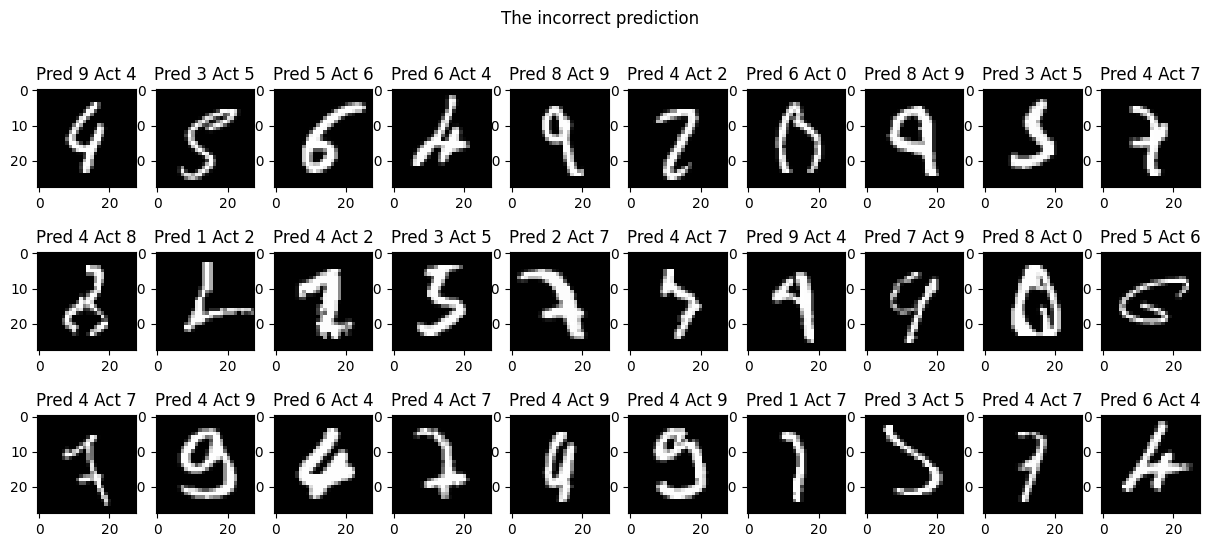

In [42]:
show_false_prediction(pred_class, X_test, y_test)

Ans : จากกราฟ และ Output ที่แสดง โมเดลใหม่ที่มีการใช้ Hyperparameter batch_size=64,epochs=20 เกิดการ Missclasify และมี Loss Funtion มากขึ้นจากเดิม และ Acc ต่ำกว่าเดิม